# Using Python and Auto ARIMA to Forecast Seasonal Time Series

* Ref: [https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c](https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c)
* Data: [https://fred.stlouisfed.org/series/IPG2211A2N](https://fred.stlouisfed.org/series/IPG2211A2N)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from IPython.display import display

## 1. Load data

In [ ]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/Electric_Production.csv', 
                 index_col=0, parse_dates=[0])
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.6803
1985-02-01,70.8479
1985-03-01,62.6166
1985-04-01,57.6106
1985-05-01,55.4467


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 409 entries, 1985-01-01 to 2019-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IPG2211A2N  409 non-null    float64
dtypes: float64(1)
memory usage: 6.4 KB


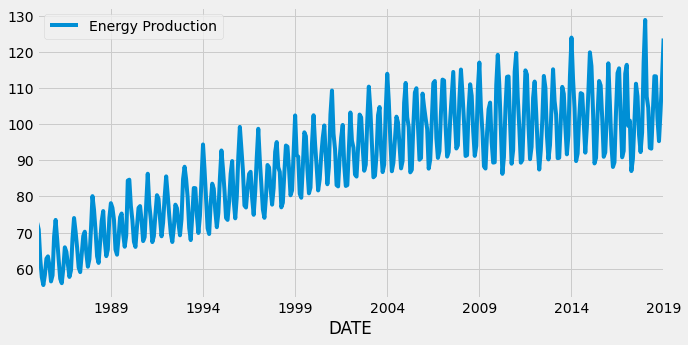

In [ ]:
df.rename(columns={'IPG2211A2N': 'Energy Production'}, inplace=True)

fig, ax = plt.subplots(figsize=(10, 5))
df.plot(ax=ax)
plt.show()

## 2. Analysis
* 檢查是否有 bias
    * 1 sample student test
      * null hypothesis: there is no effective difference between the observed sample mean and the hypothesized or stated population mean—i.e., that any measured difference is due only to chance. 
      * 就是說 sample mean = population mean
* 檢查是否有 autocorrelation
    * Ljung-Box test
    * 畫圖
* 檢查是否是 stationary
    * Dickey-Fuller test
      * null hypothesis: time series 是 non-stationary 的
      * Test statistics  <  critical value  →  reject null hypothesis
      * $p$ -value  <  0.05  →  reject null hypothesis
      * ADF < 0 (ADF 就是 test statistics)
* 做 seasonal decomposition

In [ ]:
from scipy import stats
from statsmodels.tsa.stattools import adfuller # Use augmented dickey-fuller test to check stationality

def check_time_series(time_series, window=12, bias=True, adf=True):
  # determin rolling statistics
  rolling_mean = time_series.rolling(window).mean()
  rolling_std = time_series.rolling(window).std()

  # plot rolling statistics
  fig, ax = plt.subplots(figsize=(10, 5))
  time_series.plot(ax=ax, color='blue', label='original')
  rolling_mean.plot(ax=ax, color='red', label='rolling mean')
  rolling_std.plot(ax=ax, color='black', label='rolling std')
  plt.legend()
  plt.title('Rolling mean and standard deviation')
  plt.show()

  # perform 1 sample student test
  # null hypothesis: sample mean = population mean
  if bias:
    student_test = stats.ttest_1samp(time_series, 0)[1]
    print(f"Students' criterion: p={student_test}")
    if student_test < 0.05:
      print("Because p < 0.05, we reject the null hypothesis.")
      print("--> The sample mean is not equal to population mean.\n")

  # perform Dickey-Fuller test
  # null hypothesis: the time series is non-stationary 
  if adf:
    print('Results of Dickey-Fuller test:')
    adf_test = adfuller(time_series, autolag='AIC') # AIC: Akaike information criterion (AIC), the smaller AIC the better model
    index = [
      'Test statistics (ADF)',
      'p-value',
      'Number of lags used',
      'Number of observations used'
    ]
    adf_results = pd.Series(adf_test[:4], index=index)
    for k, v in adf_test[4].items():
      adf_results[f'Critical value ({k})'] = v
    print(adf_results)
    if adf_results[1] < 0.05:
      print("Because p < 0.05, we reject the null hypothesis")
      print("--> The time series is stationary.")

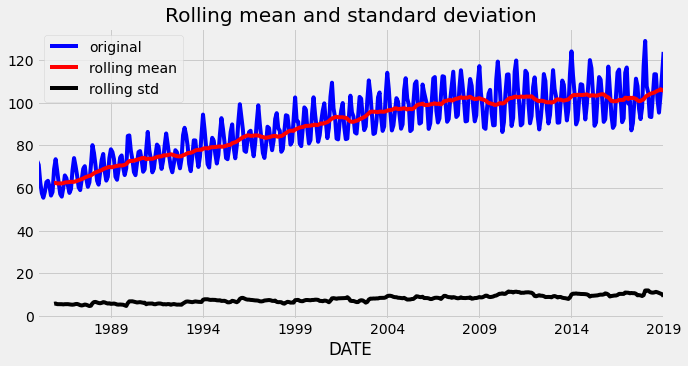

Students' criterion: p=5.4823281e-316
Results of Dickey-Fuller test:
Test statistics (ADF)           -2.334522
p-value                          0.161076
Number of lags used             15.000000
Number of observations used    393.000000
Critical value (1%)             -3.447099
Critical value (5%)             -2.868923
Critical value (10%)            -2.570703
dtype: float64


In [ ]:
check_time_series(df['Energy Production'])

* Student's test $p$-value < 0.05 $\rightarrow$ reject null hypothesis
* Dickey-Fuller test $p$-value > 0.05 $\rightarrow$ not reject null hypothesie (i.e. this time series is non-stationary)
    * Need to apply differencing to make the time series stationary

In [ ]:
# 用已有的函數畫圖
def plot_lags_autocorrelation_acf_pacf(time_series, nlags=50): # 只畫前 50 個 lags
  fig, ax = plt.subplots(2, 2, figsize=(18, 8))
  # 畫 lag_plot(), autocorrelation_plot()
  pd.plotting.lag_plot(time_series, ax=ax[0][0])
  pd.plotting.autocorrelation_plot(time_series, ax=ax[0][1])

  # 畫 plot_acf(), plot_pacf()
  from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
  plot_acf(time_series, lags=nlags, ax=ax[1][0]) 
  plot_pacf(time_series, lags=nlags, ax=ax[1][1])

  plt.tight_layout()
  plt.show()

# 自己手動計算 ACF 和 PACF 然後畫圖
def plot_calculated_acf_and_pacf(time_series, nlags=50): # 只畫前 50 個 lags
  import numpy as np
  from statsmodels.tsa.stattools import acf, pacf
  lag_acf = acf(time_series, nlags=nlags)
  lag_pacf = pacf(time_series, nlags=nlags, method='ols') # OLS: ordinary least square

  fig, ax = plt.subplots(1, 2, figsize=(18, 4))
  ax[0].plot(lag_acf)
  ax[0].axhline(y=0, linestyle='--', color='gray')
  ax[0].axhline(y=-1.96/np.sqrt(len(time_series)), linestyle='--', color='gray')
  ax[0].axhline(y=1.96/np.sqrt(len(time_series)), linestyle='--', color='gray')
  ax[0].set_title('Autocorrelation Function')

  ax[1].plot(lag_pacf)
  ax[1].axhline(y=0, linestyle='--', color='gray')
  ax[1].axhline(y=-1.96/np.sqrt(len(time_series)), linestyle='--', color='gray')
  ax[1].axhline(y=1.96/np.sqrt(len(time_series)), linestyle='--', color='gray')
  ax[1].set_title('Partical Autocorrelation Function')

  plt.tight_layout()
  plt.show()

def plot_seasonal_decomposition(time_series, model): # model=additive or multiplicative
  from statsmodels.tsa.seasonal import seasonal_decompose
  decomposition = seasonal_decompose(time_series, model=model)
  # 只畫一張圖，會很小，都擠在一起
  # fig = decomposition.plot()

  # 改成單獨畫每張圖
  trend = decomposition.trend
  seasonal = decomposition.seasonal
  residual = decomposition.resid

  fig, ax = plt.subplots(3, 1, figsize=(18, 9))
  trend.plot(ax=ax[0])
  ax[0].set_ylabel('Trend')

  seasonal.plot(ax=ax[1])
  ax[1].set_ylabel('Seasonal')

  residual.plot(ax=ax[2])
  ax[2].set_ylabel('Residual')

  plt.tight_layout()
  plt.show()

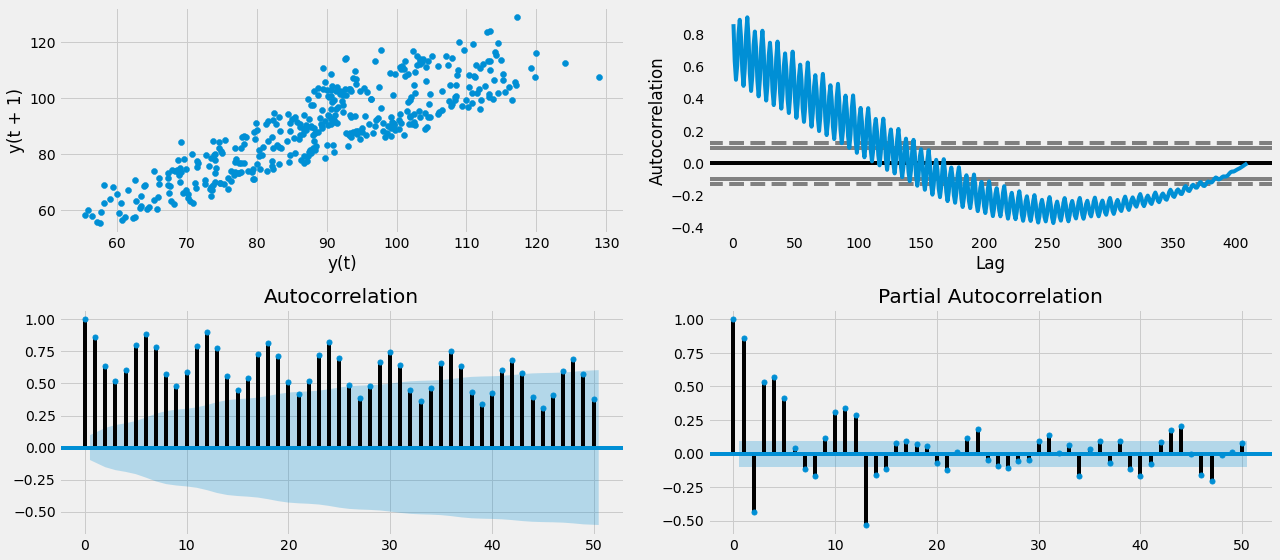

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


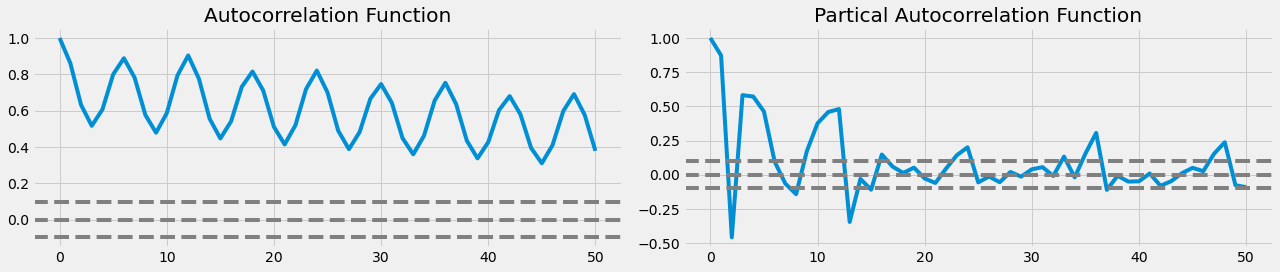

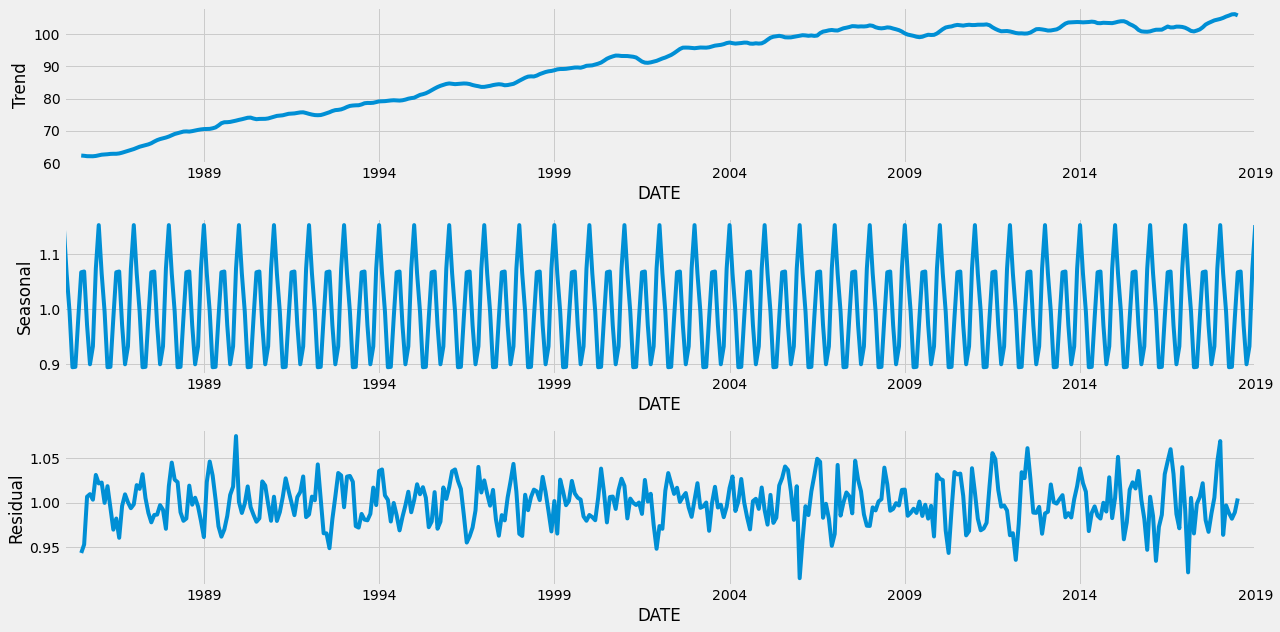

In [ ]:
plot_lags_autocorrelation_acf_pacf(df['Energy Production'])
plot_calculated_acf_and_pacf(df['Energy Production'])
plot_seasonal_decomposition(df['Energy Production'], model='multiplicative')

## 3. Forecast

In [ ]:
pip install pyramid-arima

In [ ]:
from pyramid.arima import auto_arima

stepwise_model = auto_arima(df['Energy Production'],
                            start_p=1, max_p=3,
                            d=1,
                            start_q=1, max_q=3,
                            start_P=1,
                            D=1,
                            m=12, # number of periods in each season
                            seasonal=True,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1854.847, BIC=1878.735, Fit time=7.139 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2086.046, BIC=2094.009, Fit time=0.067 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2017.677, BIC=2033.603, Fit time=1.056 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1909.698, BIC=1925.624, Fit time=1.258 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1855.462, BIC=1875.369, Fit time=4.403 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 1, 12); AIC=1839.601, BIC=1867.471, Fit time=15.117 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 12); AIC=1881.787, BIC=1905.675, Fit time=14.567 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=1835.232, BIC=1867.083, Fit time=21.324 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=1878.699, BIC=1906.569, Fit time=9.736 seconds
Fit ARIMA: order=(2, 1, 1

In [ ]:
print(stepwise_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  409
Model:             SARIMAX(1, 1, 1)x(2, 1, 2, 12)   Log Likelihood                -909.616
Date:                            Sun, 14 Jun 2020   AIC                           1835.232
Time:                                    22:10:38   BIC                           1867.083
Sample:                                         0   HQIC                          1847.850
                                            - 409                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0020      0.001     -1.579      0.114      -0.004       0.000
ar.L1          0.4928      0.045   

In [ ]:
train = df.loc['1985-01-01':'2016-12-01']
test = df.loc['2017-01-01':]

print(len(train), train)
print(len(test), test)

384             Energy Production
DATE                         
1985-01-01            72.6803
1985-02-01            70.8479
1985-03-01            62.6166
1985-04-01            57.6106
1985-05-01            55.4467
...                       ...
2016-08-01           115.5015
2016-09-01           102.2398
2016-10-01            90.8499
2016-11-01            92.6032
2016-12-01           114.0219

[384 rows x 1 columns]
25             Energy Production
DATE                         
2017-01-01           116.4746
2017-02-01            99.5393
2017-03-01           101.0063
2017-04-01            87.0374
2017-05-01            90.3591
2017-06-01           100.4412
2017-07-01           111.2371
2017-08-01           107.7583
2017-09-01            97.0813
2017-10-01            92.3020
2017-11-01            97.7214
2017-12-01           117.2377
2018-01-01           128.9071
2018-02-01           107.6711
2018-03-01           104.5716
2018-04-01            93.4491
2018-05-01            93.2405
2018-06-0

25 <class 'numpy.ndarray'>
[121.50161531 109.68551921  99.9188083   89.83840541  91.4243315
 102.6620015  112.54493477 111.86456847 100.43219953  91.30066568
  95.28934509 111.15580332 120.08746211 110.57862573 101.48350889
  89.63065672  91.39486956 102.21371657 111.60903355 110.47069472
 100.22699526  91.27247878  95.4716718  108.70782654 119.25808761]
confidence interval:
 [[-4.50314141e-03 -1.06281693e-03]
 [ 4.50523176e-01  6.38360491e-01]
 [-1.00674228e+00 -9.61066646e-01]
 [-4.92273543e-02  7.88994760e-01]
 [-4.10898666e-01 -1.66036652e-01]
 [-1.47563637e+00 -6.40316686e-01]
 [ 2.98839460e-03  6.74370929e-01]
 [ 4.49981530e+00  5.87234541e+00]]


,Prediction
DATE,
2017-01-01,121.501615
2017-02-01,109.685519
2017-03-01,99.918808
2017-04-01,89.838405
2017-05-01,91.424331


,Energy Production,Prediction
DATE,,
2017-01-01,116.4746,121.501615
2017-02-01,99.5393,109.685519
2017-03-01,101.0063,99.918808
2017-04-01,87.0374,89.838405
2017-05-01,90.3591,91.424331


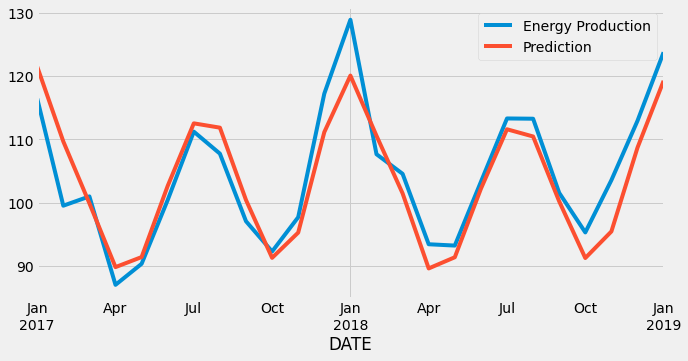

,Energy Production,Prediction
DATE,,
1985-01-01,72.6803,NaN
1985-02-01,70.8479,NaN
1985-03-01,62.6166,NaN
1985-04-01,57.6106,NaN
1985-05-01,55.4467,NaN
...,...,...
2018-09-01,101.5656,100.226995
2018-10-01,95.3203,91.272479
2018-11-01,103.5750,95.471672


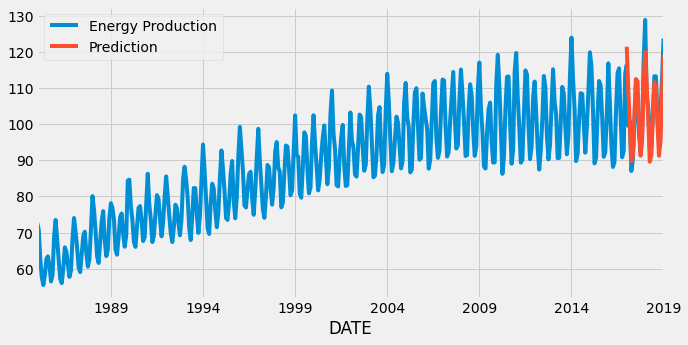

In [ ]:
stepwise_model.fit(train)

future_forecast = stepwise_model.predict(n_periods=len(test))
print(len(future_forecast), type(future_forecast))
print(future_forecast)

# confidence interval of fitted coefficients
pred_ci = stepwise_model.conf_int()
print('confidence interval:\n', pred_ci)

# 轉成 dataframe
df_forecast = pd.DataFrame(future_forecast, index=test.index, columns=['Prediction'])
display(df_forecast.head())

df_merged = pd.concat([test, df_forecast], axis=1)
display(df_merged.head())

fig, ax = plt.subplots(figsize=(10, 5))
df_merged.plot(ax=ax)
plt.show()

df_final = pd.concat([df['Energy Production'], df_forecast], axis=1)
display(df_final)
fig, ax = plt.subplots(figsize=(10, 5))
df_final.plot(ax=ax)
plt.show()